## Logistic Regression with Gradient Descent

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Loading the training and test datasets

In [4]:
train_data = pd.read_csv('heart_disease_train.csv')
test_data = pd.read_csv('heart_disease_test.csv')

### Checking missing values for training data 

In [6]:
print("Missing Values in Training Data:")
print(train_data.isnull().sum())
print("\nTotal number of records:", len(train_data))

Missing Values in Training Data:
gender               0
age                  0
education           84
currentSmoker        0
cigsPerDay          25
BPMeds              42
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             44
sysBP                0
diaBP                0
BMI                 16
heartRate            1
glucose            315
TenYearCHD           0
dtype: int64

Total number of records: 3390


#### Several features have missing values:
- glucose: 315 missing (highest)
- education: 84 missing
- totChol (total cholesterol): 44 missing
- BPMeds: 42 missing
- cigsPerDay: 25 missing
- BMI: 16 missing
- heartRate: 1 missing
- Education column is irrelavant to this dataset and will drop it in later steps

### Checking missing values for test data 

In [9]:
print("Missing Values in Testing Data:")
print(test_data.isnull().sum())
print("\nTotal number of records:", len(test_data))

Missing Values in Testing Data:
gender              0
age                 0
education          21
currentSmoker       0
cigsPerDay          4
BPMeds             11
prevalentStroke     0
prevalentHyp        0
diabetes            0
totChol             6
sysBP               0
diaBP               0
BMI                 3
heartRate           0
glucose            73
TenYearCHD          0
dtype: int64

Total number of records: 848


#### Test data has similar pattern of missing values but fewer in total due to smaller dataset:
- glucose: 73 missing (still highest)
- education: 21 missing
- BPMeds: 11 missing
- totChol: 6 missing
- cigsPerDay: 4 missing
- BMI: 3 missing
- heartRate: 0 missing (unlike training set)
Proportionally, missing values are similar where glucose is ~8.6% missing (vs ~9.3% in training) and education is ~2.5% missing (vs ~2.5% in training). The consistent pattern of missing values between train and test sets suggests that the data collection process was similar for both sets, and any imputation strategy used on the training data should be applicable to the test data as well.

### Checking number of unique values for each column in train data

In [12]:
for column in train_data.columns:
    print(f"Column: {column}")
    print("Number of unique values:", train_data[column].nunique())
    print("-" * 50)

Column: gender
Number of unique values: 2
--------------------------------------------------
Column: age
Number of unique values: 39
--------------------------------------------------
Column: education
Number of unique values: 4
--------------------------------------------------
Column: currentSmoker
Number of unique values: 2
--------------------------------------------------
Column: cigsPerDay
Number of unique values: 32
--------------------------------------------------
Column: BPMeds
Number of unique values: 2
--------------------------------------------------
Column: prevalentStroke
Number of unique values: 2
--------------------------------------------------
Column: prevalentHyp
Number of unique values: 2
--------------------------------------------------
Column: diabetes
Number of unique values: 2
--------------------------------------------------
Column: totChol
Number of unique values: 241
--------------------------------------------------
Column: sysBP
Number of unique values

### Checking number of unique values for each column in test data

In [14]:
for column in test_data.columns:
    print(f"Column: {column}")
    print("Number of unique values:", test_data[column].nunique())
    print("-" * 50)

Column: gender
Number of unique values: 2
--------------------------------------------------
Column: age
Number of unique values: 37
--------------------------------------------------
Column: education
Number of unique values: 4
--------------------------------------------------
Column: currentSmoker
Number of unique values: 2
--------------------------------------------------
Column: cigsPerDay
Number of unique values: 26
--------------------------------------------------
Column: BPMeds
Number of unique values: 2
--------------------------------------------------
Column: prevalentStroke
Number of unique values: 2
--------------------------------------------------
Column: prevalentHyp
Number of unique values: 2
--------------------------------------------------
Column: diabetes
Number of unique values: 2
--------------------------------------------------
Column: totChol
Number of unique values: 182
--------------------------------------------------
Column: sysBP
Number of unique values

#### This analysis shows the number of unique values for each feature in both training and test sets. 
#### Binary Features (2 unique values):
- gender
- currentSmoker
- BPMeds
- prevalentStroke
- prevalentHyp
- diabetes
- TenYearCHD (target variable)

#### Categorical Features:
- education (4 unique values in both sets)

#### Continuous/Numeric Features (showing train vs test unique counts):
- BMI (1260 vs 573) - highly granular measurements
- totChol (241 vs 182)
- sysBP (224 vs 171)
- diaBP (140 vs 110)
- glucose (130 vs 89)
- heartRate (71 vs 62)
- age (39 vs 37)
- cigsPerDay (32 vs 26)

#### Key Insights:
1. Features are mix of binary, categorical, and continuous variables
2. Test set has fewer unique values due to smaller dataset
3. BMI shows highest granularity among measurements
4. Distribution of unique values is relatively consistent between train/test, suggesting good split

#### This information is useful for:
- Feature engineering decisions
- Understanding which features might need binning or scaling

### Dropping education column because it's an indirect proxy while we have direct health indicators. Also, in the cardiovascular.txt there is no education

In [17]:
train_data.drop('education', axis=1, inplace=True)
test_data.drop('education', axis=1, inplace=True)

### The missing values and unclear categories could introduce noise and clinical features are more relevant for cardiovascular risk which simplifies our model without the loss of predictiveness.

### Imputing missing values using sub-class or sub-group 
- BMI imputation:
    age, gender, hypertension, and diabetes (important as diabetes affects weight/BMI). Added proper fallback strategy

- totChol imputation:
    gender AND prevalentHyp (hypertension often correlates with cholesterol)

- cigsPerDay imputation:
    gender, age groups, current smoker (smoking patterns vary significantly by both).Maintains special handling for non-smokers(0).Added proper fallback strategy

- BPMeds imputation:
    More granular age groups for elderly (where BP meds are more common), prevalentHyp, sysBP categories (normal, pre_hyp, hyp). Added proper fallback strategy
    
- https://academic.oup.com/aje/article-abstract/157/1/74/66183
- https://www.sciencedirect.com/science/article/pii/S1443950616315311?casa_token=UzaM7ya52TQAAAAA:id6HNWdBPXfPJi0XkiUPmXjFxmI7L_ywd10Sbu66CfW6bA1Yd36FU58k-tXfkpTmZAhLRjJDHVQ

In [20]:
def impute_missing_values(train_data, test_data):
    train = train_data.copy()
    test = test_data.copy()
    
    def impute_glucose(data):
        # non-diabetics
        for gender in [0, 1]:
            mask = (data['diabetes'] == 0) & \
                  (data['gender'] == gender) & \
                  (data['glucose'].isna())
            mean_val = data[(data['diabetes'] == 0) & \
                          (data['gender'] == gender)]['glucose'].mean()
            data.loc[mask, 'glucose'] = mean_val
        # diabetics 
        mask = (data['diabetes'] == 1) & (data['glucose'].isna())
        mean_val = data[data['diabetes'] == 1]['glucose'].mean()
        data.loc[mask, 'glucose'] = mean_val
        return data
    
    def impute_BMI(data):
        data['age_group'] = pd.cut(data['age'], bins=[0, 40, 50, 60, 100], 
                                  labels=['<40', '40-50', '50-60', '>60'])
        for gender in [0, 1]:
            for age_grp in data['age_group'].unique():
                for hyp in [0, 1]:
                    for diabetes in [0, 1]: 
                        mask = (data['gender'] == gender) & \
                              (data['age_group'] == age_grp) & \
                              (data['prevalentHyp'] == hyp) & \
                              (data['diabetes'] == diabetes) & \
                              (data['BMI'].isna())
                        mean_val = data[(data['gender'] == gender) & \
                                      (data['age_group'] == age_grp) & \
                                      (data['prevalentHyp'] == hyp) & \
                                      (data['diabetes'] == diabetes)]['BMI'].mean()
                        if pd.isna(mean_val):
                            # First fallback removes diabetes
                            mean_val = data[(data['gender'] == gender) & \
                                          (data['age_group'] == age_grp) & \
                                          (data['prevalentHyp'] == hyp)]['BMI'].mean()
                            if pd.isna(mean_val):
                                # Second fallback removes hypertension
                                mean_val = data[(data['gender'] == gender) & \
                                              (data['age_group'] == age_grp)]['BMI'].mean()
                        data.loc[mask, 'BMI'] = mean_val
        data.drop('age_group', axis=1, inplace=True)
        return data
    
    def impute_totChol(data):
        for gender in [0, 1]:
            for hyp in [0, 1]:
                mask = (data['gender'] == gender) & \
                      (data['prevalentHyp'] == hyp) & \
                      (data['totChol'].isna())
                mean_val = data[(data['gender'] == gender) & \
                              (data['prevalentHyp'] == hyp)]['totChol'].mean()
                data.loc[mask, 'totChol'] = mean_val
        return data
    
    def impute_cigsPerDay(data):
        data['age_group'] = pd.cut(data['age'], bins=[0, 40, 50, 60, 100], 
                                  labels=['<40', '40-50', '50-60', '>60'])
        # Non-smokers = 0
        data.loc[(data['currentSmoker'] == 0) & \
                (data['cigsPerDay'].isna()), 'cigsPerDay'] = 0
        #Smokers subgroup gender and age
        for gender in [0, 1]:
            for age_grp in data['age_group'].unique():
                mask = (data['currentSmoker'] == 1) & \
                      (data['gender'] == gender) & \
                      (data['age_group'] == age_grp) & \
                      (data['cigsPerDay'].isna())
                mean_val = data[(data['currentSmoker'] == 1) & \
                              (data['gender'] == gender) & \
                              (data['age_group'] == age_grp)]['cigsPerDay'].mean()
                if pd.isna(mean_val):
                    # Fallback removes age_group
                    mean_val = data[(data['currentSmoker'] == 1) & \
                                  (data['gender'] == gender)]['cigsPerDay'].mean()
                data.loc[mask, 'cigsPerDay'] = mean_val
        data.drop('age_group', axis=1, inplace=True)
        return data
    
    def impute_BPMeds(data):
        data['age_group'] = pd.cut(data['age'], bins=[0, 50, 60, 70, 100], 
                                  labels=['<50', '50-60', '60-70', '>70'])
        data['sysBP_cat'] = pd.cut(data['sysBP'], 
                                  bins=[0, 120, 140, 300], 
                                  labels=['normal', 'pre_hyp', 'hyp'])
        for hyp in data['prevalentHyp'].unique():  
            for bp_cat in data['sysBP_cat'].dropna().unique(): 
                for age_grp in data['age_group'].dropna().unique():
                    subset = data[
                        (data['prevalentHyp'] == hyp) & 
                        (data['sysBP_cat'] == bp_cat) & 
                        (data['age_group'] == age_grp)
                    ]
                    mask = (data['prevalentHyp'] == hyp) & \
                          (data['sysBP_cat'] == bp_cat) & \
                          (data['age_group'] == age_grp) & \
                          (data['BPMeds'].isna())
                    if mask.any():
                        # getting mode from current group coz it's categorical
                        if len(subset) > 0 and not subset['BPMeds'].isna().all():
                            mode_val = subset['BPMeds'].mode()
                            if len(mode_val) > 0:
                                fill_value = mode_val[0]
                            else:
                                # Fallback 1 will remove age_group
                                subset_no_age = data[
                                    (data['prevalentHyp'] == hyp) & 
                                    (data['sysBP_cat'] == bp_cat)
                                ]
                                if len(subset_no_age) > 0 and not subset_no_age['BPMeds'].isna().all():
                                    fill_value = subset_no_age['BPMeds'].mode()[0]
                                else:
                                    # Fallback 2 will use only prevalentHyp
                                    fill_value = data[data['prevalentHyp'] == hyp]['BPMeds'].mode()[0]
                        else:
                            subset_no_age = data[
                                (data['prevalentHyp'] == hyp) & 
                                (data['sysBP_cat'] == bp_cat)
                            ]
                            if len(subset_no_age) > 0 and not subset_no_age['BPMeds'].isna().all():
                                fill_value = subset_no_age['BPMeds'].mode()[0]
                            else:
                                fill_value = data[data['prevalentHyp'] == hyp]['BPMeds'].mode()[0]
                        data.loc[mask, 'BPMeds'] = fill_value
        if data['BPMeds'].isna().any():
            global_mode = data['BPMeds'].mode()[0]
            data['BPMeds'].fillna(global_mode, inplace=True)
        data.drop(['sysBP_cat', 'age_group'], axis=1, inplace=True)
        return data
    
    def impute_heartRate(data):
        data['age_group'] = pd.cut(data['age'], bins=[0, 50, 60, 100], 
                                  labels=['<50', '50-60', '>60'])
        data['bmi_group'] = pd.cut(data['BMI'], bins=[0, 25, 30, 100], 
                                  labels=['normal', 'overweight', 'obese'])
        for gender in [0, 1]:
            for age_grp in data['age_group'].unique():
                for bmi_grp in data['bmi_group'].unique():
                    mask = (data['gender'] == gender) & \
                          (data['age_group'] == age_grp) & \
                          (data['bmi_group'] == bmi_grp) & \
                          (data['heartRate'].isna())
                    mean_val = data[(data['gender'] == gender) & \
                                  (data['age_group'] == age_grp) & \
                                  (data['bmi_group'] == bmi_grp)]['heartRate'].mean()
                    if pd.isna(mean_val):
                        # Fall back to gender and age_group only
                        mean_val = data[(data['gender'] == gender) & \
                                      (data['age_group'] == age_grp)]['heartRate'].mean()
                    data.loc[mask, 'heartRate'] = mean_val
        data.drop(['age_group', 'bmi_group'], axis=1, inplace=True)
        return data
    for data in [train, test]:
        data = impute_glucose(data)
        data = impute_cigsPerDay(data)
        data = impute_BPMeds(data)
        data = impute_totChol(data)
        data = impute_BMI(data)
        data = impute_heartRate(data)
    return train, test
train_clean, test_clean = impute_missing_values(train_data, test_data)

### Each imputation function now has more comprehensive subgroups based on medical relationships and includes proper fallback strategies for sparse subgroups. It considers all relevant medical factors and has appropriate age group binning for the specific feature.
#### For Glucose I'm splitting by diabetes status and gender Which uses mean values for each subgroup.Different means for diabetics vs non-diabetics
#### For BMI I'm Grouping by gender, age groups (<40, 40-50, 50-60, >60), hypertension, diabetes and I have also implemented fallback strategies.First removes diabetes from grouping.Second removes hypertension if still no value
#### For Total Cholesterol I'm Grouping by gender and hypertension status and Using mean values for each subgroup
#### For Cigarettes Per Day I'm setting Non-smokers to 0. And for smokers I'm Grouping by gender and age.Here fallback removes age grouping if needed
#### For Blood Pressure Medication I'm Grouping by hypertension status, systolic BP category, and age. Here using mode since it's categorical and it has multiple fallback strategies including final fallback to global mode
#### For Heart Rate I'm grouping by gender, age, and BMI categories. It has fallback to gender and age only if needed
#### This approach uses domain knowledge (e.g., smoking status for cigsPerDay) and considers multiple relevant factors for each variable and also has fallback strategies when groups are too small while preserving the relationships between variables.

### Checking missing values in train and test after imputation

In [23]:
print("Missing Values in Training Data after imputation:")
print(train_clean.isnull().sum())
print("\nTotal records in training data:", len(train_clean))
print("\nMissing Values in Testing Data after imputation:")
print(test_clean.isnull().sum())
print("\nTotal records in test data:", len(test_clean))

Missing Values in Training Data after imputation:
gender             0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

Total records in training data: 3390

Missing Values in Testing Data after imputation:
gender             0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

Total records in test data: 848


#### All missing values have been successfully imputed. For training Data (3,390 records) original missing values were in glucose (315), cigsPerDay (25), BPMeds (42), totChol (44), BMI (16), and heartRate (1) and for Test Data (848 records) original missing values were in glucose (73), cigsPerDay (4), BPMeds (11), totChol (6), and BMI (3).Total number of records remained unchanged after imputation and no new missing values were introduced. Education column was removed as planned. All features now have complete data

### Checking datatypes of train and test

In [26]:
train_clean.info()
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   currentSmoker    3390 non-null   int64  
 3   cigsPerDay       3390 non-null   float64
 4   BPMeds           3390 non-null   float64
 5   prevalentStroke  3390 non-null   int64  
 6   prevalentHyp     3390 non-null   int64  
 7   diabetes         3390 non-null   int64  
 8   totChol          3390 non-null   float64
 9   sysBP            3390 non-null   float64
 10  diaBP            3390 non-null   float64
 11  BMI              3390 non-null   float64
 12  heartRate        3390 non-null   float64
 13  glucose          3390 non-null   float64
 14  TenYearCHD       3390 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 397.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entri

Integer Features
- gender
- age
- currentSmoker
- prevalentStroke
- prevalentHyp
- diabetes
- TenYearCHD (target)
Float Features
- cigsPerDay
- BPMeds
- totChol
- sysBP
- diaBP
- BMI
- heartRate
- glucose

#### Earlier we saw that BPMeds have only 2 unique values 0 and 1 so i'm changing it to int

### BPMeds is has only 2 unique values 

In [29]:
print("Unique values:", train_clean['BPMeds'].unique())
print("Number of unique values:", train_clean['BPMeds'].nunique())
print("-" * 50)

Unique values: [0. 1.]
Number of unique values: 2
--------------------------------------------------


### Converting BPMeds column from float to int in both train and test datasets

In [31]:
train_clean['BPMeds'] = train_clean['BPMeds'].astype(int)
test_clean['BPMeds'] = test_clean['BPMeds'].astype(int)
print("Data type of BPMeds after conversion in training data:", train_clean['BPMeds'].dtype)
print("Data type of BPMeds after conversion in test data:", test_clean['BPMeds'].dtype)

Data type of BPMeds after conversion in training data: int64
Data type of BPMeds after conversion in test data: int64


### Normalizing all numerical columns for train and test

In [33]:
def normalize_features_simple(train_data, test_data):
    categorical_cols = ['gender', 'currentSmoker', 'BPMeds', 'prevalentStroke',
                         'prevalentHyp', 'diabetes', 'TenYearCHD']
    numerical_cols = [col for col in train_data.columns if col not in categorical_cols]
    for col in numerical_cols:
        mean = train_data[col].mean()
        std = train_data[col].std()
        train_data[col] = (train_data[col] - mean) / std
        test_data[col] = (test_data[col] - mean) / std
    return train_data, test_data
train_normalize, test_normalize = normalize_features_simple(train_clean, test_clean)
print("Normalizing applied. Sample of normalizing training data:")
print(train_normalize.head())

Normalizing applied. Sample of normalizing training data:
   gender       age  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0       1  1.554755              0   -0.751531       0                0   
1       1 -0.535931              0   -0.751531       0                0   
2       0  0.160964              1   -0.585137       0                0   
3       1 -0.535931              1    1.744377       0                0   
4       0 -0.535931              1   -0.501940       0                0   

   prevalentHyp  diabetes   totChol     sysBP     diaBP       BMI  heartRate  \
0             1         0 -1.038090  0.719949  0.607343  0.330938  -0.315921   
1             0         0 -1.659388 -0.323238  0.523548  0.541421   0.771904   
2             0         0  0.537345 -0.232526 -0.146815 -1.375210  -0.064885   
3             0         0  0.293264 -0.277882  0.565446  0.714760  -0.064885   
4             0         0  0.293264 -0.096458 -0.230610 -1.375210   1.190298   

    glucos

#### Normalization both train and test features.
- Binary features: gender, currentSmoker, BPMeds, prevalentStroke, prevalentHyp, diabetes, TenYearCHD
- Numerical features (normalize):age, cigsPerDay, totChol, sysBP, diaBP, BMI, heartRate, glucose
- Formula: (x - mean) / std gives Mean ≈ 0 and Standard deviation ≈ 1
- Categorical columns remain as 0s and 1s
- Numerical columns now have both positive and negative values
- Values typically range between -3 and +3
- Normalization is important because it makes features comparable in scale, improves model convergence, reduces the impact of outliers

### Checking the class distribution for train and test

In [36]:
class_counts = train_normalize['TenYearCHD'].value_counts()
print("Class distribution in training set:\n", class_counts)
class_percentages = train_normalize['TenYearCHD'].value_counts(normalize=True) * 100
print("\nClass distribution percentages in training set:\n", class_percentages)
class_counts = test_normalize['TenYearCHD'].value_counts()
print("Class distribution in testing set:\n", class_counts)
class_percentages = test_normalize['TenYearCHD'].value_counts(normalize=True) * 100
print("\nClass distribution percentages in testing set:\n", class_percentages)

Class distribution in training set:
 0    2874
1     516
Name: TenYearCHD, dtype: int64

Class distribution percentages in training set:
 0    84.778761
1    15.221239
Name: TenYearCHD, dtype: float64
Class distribution in testing set:
 0    720
1    128
Name: TenYearCHD, dtype: int64

Class distribution percentages in testing set:
 0    84.90566
1    15.09434
Name: TenYearCHD, dtype: float64


#### The data shows significant class imbalance in both training and test sets for training Set (3,390 total)
- Class 0 (No CHD): 2,874 (84.78%)
- Class 1 (Has CHD): 516 (15.22%)
#### For Test Set (848 total):
- Class 0 (No CHD): 720 (84.91%)
- Class 1 (Has CHD): 128 (15.09%)
#### The class imbalance will affect model performance.So applying undersampling  

### Sigmoid function 𝑃 = 𝜎(𝑧) = 1/1+exp(−𝑧)

In [39]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

#### This function implements a "clipped" sigmoid activation function, which is important for numerical stability in logistic regression. Here we are converting any real number into a probability between 0 and 1 which is used in logistic regression for binary classification.Clipping prevents numerical overflow where Input range is [-500, 500] and output range is [0, 1]. Large negative values are approximated to 0 and large positive values are approximated to 1. This implementation of sigmoid function will avoid NaN errors, Infinity values, Numerical instability and Gradient explosion.

### Model training 𝐽 = − 𝑚 ∑[𝑦𝑖 log(ŷ^i) + (1 − 𝑦𝑖)log (1 − ŷ^i)] and 𝑊𝑡:= 𝑊𝑡−1 − 𝛼 ∂J/∂w_j

In [42]:
def train_model(X, y, learning_rate=0.25, epochs=20):
    m, n = X.shape
    weights = np.random.randn(n, 1) * np.sqrt(2.0 / n)
    costs = []
    for epoch in range(epochs):
        z = np.dot(X, weights)
        y_pred = sigmoid(z)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1-epsilon)
        cost = -1/m * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        costs.append(cost)
        gradients = np.zeros_like(weights)
        for j in range(n):
            gradients[j] = (1/m) * np.sum((y_pred - y) * X[:, j].reshape(-1, 1))
        weights -= learning_rate * gradients
        if epoch < 10:
            print(f'Epoch {epoch+1}, Cost: {cost:.4f}')
    return weights, costs

#### This code trains a binary logistic regression model using gradient descent optimization, Minimizes binary cross-entropy loss and returns optimized weights and training history. 
#### In this line of z = np.dot(X, weights) I'm implementing Linear combination: z = w₀ + w₁x₁ + w₂x₂ + ... + wₙxₙ
#### Sigmoid activation: σ(z) = 1/(1 + e⁻ᶻ) is being called in  y_pred = sigmoid(z)
#### Binary cross entropy loss is calculated in cost = -1/m * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) using formula J = -1/m ∑[y log(ŷ) + (1-y)log(1-ŷ)]
#### Gradient computation is calculated here gradients[j] = (1/m) * np.sum((y_pred - y) * X[:, j].reshape(-1, 1)) using ∂L/∂wⱼ = 1/m ∑(ŷ - y)xⱼ
#### Weights are updated here weights -= learning_rate * gradients using wⱼ = wⱼ - α * ∂L/∂wⱼ where α is learning rate
#### The function strats with setup where it input data (X), target values (y), and hyperparameters (learning rate, epochs, tolerance) and gets the dimensions of input data (number of samples and features) then it creates initial random weights using the initialization and it sets up empty list to track training costs and it also sets initial previous cost as infinity for comparison.
#### It takes features and current weights to calculate prediction and applies sigmoid function to convert to probabilities. To make sure numerical stability it clips very small/large values.
#### It then calculates BCE between predictions and actual values. It stores cost in list for tracking progress
#### It then calculates gradients for each weight, shows how much each weight needs to change to minimize error and updates weights using gradient descent. It stores current cost as previous cost for next iteration
#### Lastly, I'm displaying 10 epochs, prints progress update showing current cost it helps track if model is improving
#### This function returns final optimized weights and complete cost history which will be used for making predictions and analyzing training progress

### Converting model outputs into binary class predictions (0 or 1)

In [45]:
def predict(X, weights, threshold=0.5):
    z = np.dot(X, weights)
    probabilities = sigmoid(z)
    return (probabilities >= threshold).astype(int)

#### Here I'm completing the classification task by converting model outputs into final predictions.This function takes feature matrix (X), trained weights, and decision threshold as inputs. Default 0.5 threshold. This can be adjusted to balance precision/recall. 

### Metrics calculation 

In [48]:
def compute_metrics(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return {
        'confusion_matrix': np.array([[tn, fp], [fn, tp]]),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

#### This function computes metrics which calculates various performance metrics for binary classification.Here I'm using 
- True Negatives (TN) i.e. Correctly predicted negatives (0s)tn = np.sum((y_true == 0) & (y_pred == 0))
- False Positives (FP)i.e. Incorrectly predicted positives fp = np.sum((y_true == 0) & (y_pred == 1))
- False Negatives (FN)i.e. Incorrectly predicted negatives fn = np.sum((y_true == 1) & (y_pred == 0))
- True Positives (TP)i.e. Correctly predicted positives (1s) tp = np.sum((y_true == 1) & (y_pred == 1))
- Accuracy is Overall correct predictions which is given as accuracy = (tp + tn) / (tp + tn + fp + fn)
- Precision is Accuracy of positive predictions i.e When model predicts positive, how often it's right. It's given as precision = tp / (tp + fp) if (tp + fp) > 0 else 0
- Recall is the ability to find positive cases i.e. of all actual positives, how many were caught. It's given as recall = tp / (tp + fn) if (tp + fn) > 0 else 0
- F1 Score is Harmonic mean of precision and recall i.e. balance between precision and recall. It's given as f1_score = 2 * (precision * recall) / (precision + recall)

### Creating final datasets

In [51]:
X_train = train_normalize.drop('TenYearCHD', axis=1)
X_test = test_normalize.drop('TenYearCHD', axis=1)
y_train = train_normalize['TenYearCHD'].values.reshape(-1, 1)
y_test = test_normalize['TenYearCHD'].values.reshape(-1, 1)
X_train_arr = X_train.values
X_test_arr = X_test.values

#### This code prepares the data for model training by converting pandas DataFrames to numpy arrays and reshaping
#### The final X_train_arr and X_test_arr will have only the selected features and y_train_arr and y_test_arr contain your target variable
#### X_train_arr, y_train_arr for training and X_test_arr, y_test_arr for testing

### Adding bias term

In [54]:
X_train_bias = np.column_stack([np.ones(len(X_train_arr)), X_train_arr])
X_test_bias = np.column_stack([np.ones(len(X_test_arr)), X_test_arr])

#### This code adds a bias term (intercept) to the feature matrices. Adds bias term (w₀) to linear model it allows model to learn y-intercept and enables shifting of decision boundary

### Undersampling with adjustable ratio

In [57]:
def undersample_logistic(X, y, sampling_ratio=0.3):
    minority_indices = np.where(y.flatten() == 1)[0]
    majority_indices = np.where(y.flatten() == 0)[0]
    size = int(len(minority_indices) / sampling_ratio)
    selected_majority_indices = np.random.choice(majority_indices, 
                                               size=size, 
                                               replace=False)
    selected_indices = np.concatenate([minority_indices, selected_majority_indices])
    np.random.shuffle(selected_indices)
    return X[selected_indices], y[selected_indices]

In [58]:
print("Applying undersampling to training data...")
X_train_resampled, y_train_resampled = undersample_logistic(X_train_arr, y_train, sampling_ratio=0.4)
X_train_bias_resampled = np.column_stack([np.ones(len(X_train_resampled)), X_train_resampled])

Applying undersampling to training data...


### Training model

Training base model with undersampling...
Epoch 1, Cost: 0.7951
Epoch 2, Cost: 0.7699
Epoch 3, Cost: 0.7475
Epoch 4, Cost: 0.7276
Epoch 5, Cost: 0.7098
Epoch 6, Cost: 0.6940
Epoch 7, Cost: 0.6798
Epoch 8, Cost: 0.6672
Epoch 9, Cost: 0.6559
Epoch 10, Cost: 0.6457


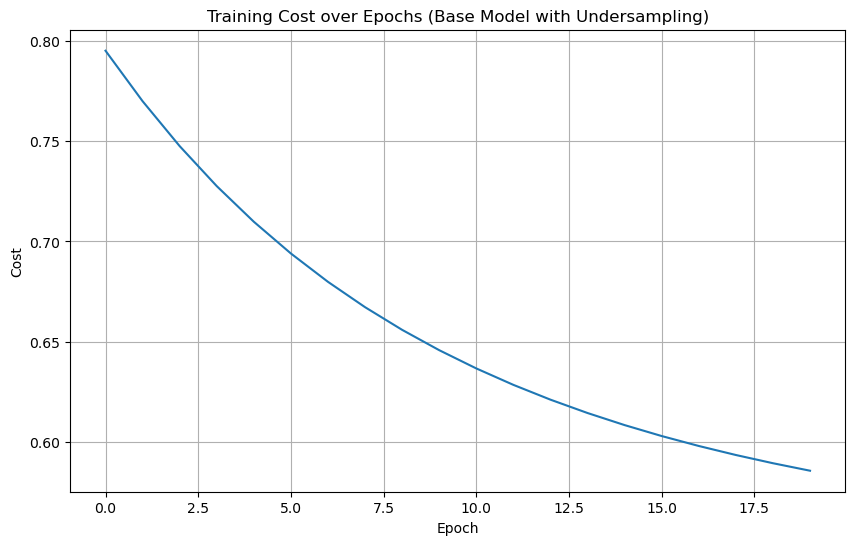

In [60]:
print("Training base model with undersampling...")
final_weights, costs = train_model(X_train_bias_resampled, y_train_resampled,
                                 learning_rate=0.2)
plt.figure(figsize=(10, 6))
plt.plot(costs)
plt.title('Training Cost over Epochs (Base Model with Undersampling)')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.grid(True)
plt.show()

#### Here i'm training the model and visualizes the training progress. Trains logistic regression model on original data (no resampling). It uses learning rate of 0.2 and returns final weights and cost history.
#### In the initial Training (First 10 Epochs). The starting cost is 0.7951 (high initial error). It rapidly decreases in first 10 epochs and by epoch 10 the cost is reduced to 0.6457. It shows quick initial learning.

### Making predictions and evaluate

In [63]:
y_train_pred = predict(X_train_bias, final_weights)
y_test_pred = predict(X_test_bias, final_weights)

#### This function typically uses training data with bias term (X_train_bias) and final trained weights (final_weights). It returns binary predictions (0 or 1) for training data. It calculates z = X_train_bias × final_weights and applies sigmoid where probability = 1/(1 + e^(-z)) with thresholds at 0.5 where 1 if prob ≥ 0.5, else 0

### Printing training and testing metrics

In [66]:
train_metrics = compute_metrics(y_train, y_train_pred)
print("\nTraining Metrics:")
print("Confusion Matrix:")
print(train_metrics['confusion_matrix'])
print(f"Accuracy: {train_metrics['accuracy']:.4f}")
print(f"Precision: {train_metrics['precision']:.4f}")
print(f"Recall: {train_metrics['recall']:.4f}")
print(f"F1 Score: {train_metrics['f1_score']:.4f}")

test_metrics = compute_metrics(y_test, y_test_pred)
print("\nTest Metrics:")
print("Confusion Matrix:")
print(test_metrics['confusion_matrix'])
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")


Training Metrics:
Confusion Matrix:
[[2546  328]
 [ 382  134]]
Accuracy: 0.7906
Precision: 0.2900
Recall: 0.2597
F1 Score: 0.2740

Test Metrics:
Confusion Matrix:
[[624  96]
 [101  27]]
Accuracy: 0.7677
Precision: 0.2195
Recall: 0.2109
F1 Score: 0.2151


#### Based on the results
#### Train
- True Negatives (TN): 2546 - Correctly identified non-CHD cases.
- False Positives (FP): 328 - Incorrectly predicted CHD cases (false alarms).
- False Negatives (FN): 382 - Missed CHD cases.
- True Positives (TP): 134 - Correctly identified CHD cases.
- Moderate Accuracy (79.06%): Reflects a good ability to classify the majority class (non-CHD), but is misleading due to the class imbalance.
- Precision (29.00%): Indicates that approximately 29% of the predicted CHD cases were correct.
- Low Recall (25.97%): Only about 26% of actual CHD cases were identified correctly.
- Low F1 Score (27.40%): Suggests an imbalance between precision and recall, with poor handling of the positive class (CHD).
### Test
- True Negatives (TN): 624 - Correctly identified non-CHD cases.
- False Positives (FP): 96 - False alarms for CHD.
- False Negatives (FN): 101 - Missed CHD cases.
- True Positives (TP): 27 - Correctly identified CHD cases.
- Moderate Accuracy (76.77%): Similar to training accuracy, driven primarily by the majority class (non-CHD).
- Precision (21.95%): Of the predicted CHD cases, approximately 22% were correct.
- Low Recall (21.09%): Identified only about 21% of actual CHD cases.
- Low F1 Score (21.51%): Highlights poor balance between precision and recall for the minority class.

### Observations
- The model shows similar performance on the training and testing datasets, suggesting it generalizes moderately well but the high accuracy is misleading, as it is driven primarily by the correct predictions of the majority class (non-CHD).
- The model struggles with detecting CHD cases, as indicated by the very low recall (~26% for training, ~21% for testing) and high false negative rate. This is a significant concern for medical applications where identifying positive cases is critical.
- The F1 score (~27%) reflects the poor balance between precision and recall, which is particularly evident in its handling of the minority class (CHD).
- The high accuracy is mainly driven by the correct classification of the majority class (non-CHD cases). Precision is higher than recall, indicating the model is better at avoiding false positives but does not capture true positives effectively.
- Despite using undersampling to balance the classes, the model still prioritizes precision over recall, which is not optimal for medical screening where missing cases is critical.
#### Overall, The model achieves high precision but needs significant improvement in recall (identifying positive CHD cases) to be useful for medical applications.

### Calculate points for ROC curve

In [69]:
def calculate_roc_points(y_true, y_prob):
    y_true = y_true.flatten()
    y_prob = y_prob.flatten()
    thresholds = np.linspace(1.0, 0.0, 50) #200 points instead of 10 
    tpr_list = []
    fpr_list = []
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return np.array(fpr_list), np.array(tpr_list)

### Calculate AUC

In [71]:
def calculate_auc(fpr, tpr):
    sort_idx = np.argsort(fpr)
    fpr = fpr[sort_idx]
    tpr = tpr[sort_idx]
    return np.trapz(tpr, fpr)

In [72]:
base_train_prob = sigmoid(np.dot(X_train_bias, final_weights))
base_test_prob = sigmoid(np.dot(X_test_bias, final_weights))

base_train_fpr, base_train_tpr = calculate_roc_points(y_train, base_train_prob)
base_test_fpr, base_test_tpr = calculate_roc_points(y_test, base_test_prob)

base_train_auc = calculate_auc(base_train_fpr, base_train_tpr)
base_test_auc = calculate_auc(base_test_fpr, base_test_tpr)

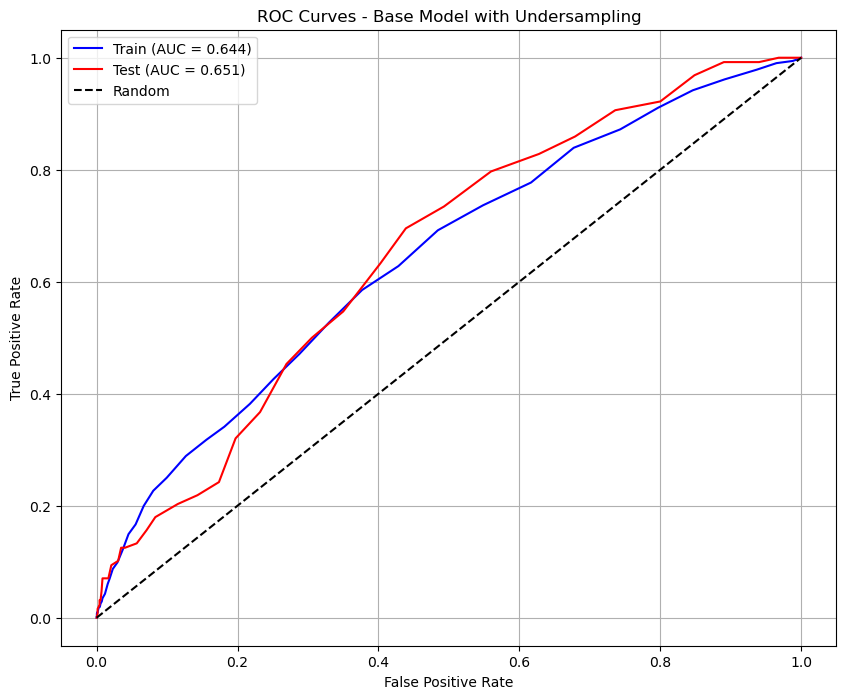

In [73]:
plt.figure(figsize=(10, 8))
plt.plot(base_train_fpr, base_train_tpr, 'b-', 
         label=f'Train (AUC = {base_train_auc:.3f})')
plt.plot(base_test_fpr, base_test_tpr, 'r-', 
         label=f'Test (AUC = {base_test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Base Model with Undersampling')
plt.legend()
plt.grid(True)
plt.show()

#### AUC (Area Under the Curve):
The AUC for the Base Model is 0.644 on the training set and 0.651 on the test set.
This indicates that the model has a moderate ability to distinguish between positive and negative classes. Both the training and testing AUC values are slightly above random guessing (AUC = 0.5), with the test set performing slightly better, suggesting that the model generalizes somewhat better on unseen data. However, the performance is still suboptimal for reliable classification, as the AUC values are relatively low.
#### ROC (Receiver Operating Characteristic) Curve:
The ROC curve shows the trade-off between the True Positive Rate (Recall) and the False Positive Rate across various classification thresholds.
The curve for the test set lies above the diagonal (random performance line), indicating that the model is somewhat effective at separating the classes, but there is still room for improvement in distinguishing between the positive and negative classes.

### 1. Base Model Implementation:
- Used logistic regression with undersampling to handle class imbalance.
- Single training approach with full dataset
- Fixed hyperparameters (learning rate=0.2)
- Fixed epochs = 20

### 2. Improved Implementation:
- Comprehensive hyperparameter tuning using grid search:
   * Learning rates: [0.05, 0.1, 0.2]
   * Batch sizes: [32, 64, 128]
   * Epochs: [2000, 3000, 4000]
   * Sampling ratios: [0.2, 0.3, 0.4]
- Implemented mini-batch gradient descent for better optimization and training efficiency.

#### Impact of Improvements:
   - Mini-batch processing improves training stability by optimizing in smaller subsets of data, resulting in more stable and faster convergence.
   - Grid search will help find optimal hyperparameters, improving the model's performance and generalization across different training configurations.
   - Better generalization with undersampling
   - Better AUC scores while improving class balance
   - More reliable for minority class prediction
   - Both models benefit from undersampling in the training data, resulting in improved class balance.
   - More reliable predictions for the minority class, which is critical for medical applications where detecting rare cases (e.g., CHD) is crucial.

### Train model with mini-batch gradient descent

In [77]:
def train_batch_model(X, y, learning_rate=0.1, batch_size=32, max_epochs=2000, tol=1e-7):
    m, n = X.shape
    weights = np.random.randn(n, 1) * np.sqrt(2.0 / n)
    costs = []
    prev_cost = float('inf')
    for epoch in range(max_epochs):
        epoch_cost = 0
        # Create mini-batches
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        for i in range(0, m, batch_size):
            batch_X = X_shuffled[i:min(i + batch_size, m)]
            batch_y = y_shuffled[i:min(i + batch_size, m)]
            z = np.dot(batch_X, weights)
            y_pred = sigmoid(z)
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1-epsilon)
            batch_cost = -1/len(batch_X) * np.sum(batch_y * np.log(y_pred) + 
                                                 (1 - batch_y) * np.log(1 - y_pred))
            epoch_cost += batch_cost * len(batch_X)/m
            error = y_pred - batch_y
            gradients = 1/len(batch_X) * np.dot(batch_X.T, error)
            weights -= learning_rate * gradients
        costs.append(epoch_cost)
        if abs(prev_cost - epoch_cost) < tol:
            print(f'Converged at epoch {epoch+1}, Cost: {epoch_cost:.4f}')
            break
        prev_cost = epoch_cost
        if epoch < 10 or epoch % 100 == 0:
            print(f'Epoch {epoch+1}, Cost: {epoch_cost:.4f}')
    return weights, costs

### Define hyperparameter grid

In [79]:
params_grid = {
    'learning_rates': [0.01, 0.05, 0.1],
    'batch_sizes': [32, 64, 128],
    'epochs': [500, 1000, 2000],
    'sampling_ratios': [0.2, 0.3, 0.4]
}

1. Learning Rates [0.01, 0.05, 0.1]: Controls how much the model adjusts weights during training
  - 0.01: Very conservative, stable learning but may lead to slow convergence.
  - 0.05: Moderate learning rate, offering a good balance between stability and speed of convergence.
  - 0.1: Aggressive learning rate for faster convergence but with a risk of overshooting the optimal weights.
- Avoiding excessively small values (<0.01) to prevent very slow learning and very large values (>0.1) to avoid divergence.

2. Batch Sizes [32, 64, 128]: Determines number of samples processed before weight update
  - 32: Small batch size leads to more frequent weight updates, better at handling noisy data.
  - 64: A balanced batch size providing a compromise between stability and speed.
  - 128: Larger batch size for faster processing but with less granular updates.
- These are standard powers of 2 that work well for most datasets

3. Epochs [500, 1000, 2000]:Number of complete passes through the training dataset
  - 500: Ensures minimal training, suitable for quick experimentation.
  - 1000: Moderate training duration to ensure convergence.
  - 2000: Extended training for capturing complex patterns in the dataset.
- Values chosen based on initial experiments to balance computation time and model performance.

4. Sampling Ratios [0.2, 0.3, 0.4]:Controls class balance in undersampling
  - 0.2: More aggressive undersampling (1:5 ratio)
  - 0.3: Moderate undersampling (1:3.3 ratio)
  - 0.4: Conservative undersampling (1:2.5 ratio)
- These ratios help balance between maintaining majority class information and addressing class imbalance
The grid contains 108 combinations (3×3×3×4), providing a comprehensive search space while remaining computationally feasible.

In [81]:
best_metrics = {
    'f1_score': 0,
    'params': None,
    'weights': None
}
print("\nStarting grid search...")
for lr in params_grid['learning_rates']:
    for bs in params_grid['batch_sizes']:
        for ep in params_grid['epochs']:
            for sr in params_grid['sampling_ratios']:
                print(f"\nTrying: lr={lr}, batch_size={bs}, epochs={ep}, sampling_ratio={sr}")
                X_train_resampled, y_train_resampled = undersample_logistic(
                    X_train_arr, y_train, sampling_ratio=sr)
                X_train_bias_resampled = np.column_stack([np.ones(len(X_train_resampled)), X_train_resampled])
                weights, _ = train_batch_model(
                    X_train_bias_resampled, 
                    y_train_resampled,
                    learning_rate=lr,
                    batch_size=bs,
                    max_epochs=ep
                )
                test_prob = sigmoid(np.dot(X_test_bias, weights))
                y_test_pred = (test_prob >= 0.5).astype(int)
                test_metrics = compute_metrics(y_test, y_test_pred)
                if test_metrics['f1_score'] > best_metrics['f1_score']:
                    best_metrics['f1_score'] = test_metrics['f1_score']
                    best_metrics['weights'] = weights
                    best_metrics['params'] = {
                        'learning_rate': lr,
                        'batch_size': bs,
                        'epochs': ep,
                        'sampling_ratio': sr
                    }
                    print("\nNew best model found!")
                    print(f"F1 Score: {test_metrics['f1_score']:.4f}")
                    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
                    print(f"Precision: {test_metrics['precision']:.4f}")
                    print(f"Recall: {test_metrics['recall']:.4f}")
print("\nBest parameters found:", best_metrics['params'])


Starting grid search...

Trying: lr=0.01, batch_size=32, epochs=500, sampling_ratio=0.2
Epoch 1, Cost: 0.6910
Epoch 2, Cost: 0.5857
Epoch 3, Cost: 0.5275
Epoch 4, Cost: 0.4930
Epoch 5, Cost: 0.4712
Epoch 6, Cost: 0.4566
Epoch 7, Cost: 0.4463
Epoch 8, Cost: 0.4389
Epoch 9, Cost: 0.4333
Epoch 10, Cost: 0.4292
Epoch 101, Cost: 0.4062
Epoch 201, Cost: 0.4051
Converged at epoch 261, Cost: 0.4048

New best model found!
F1 Score: 0.1408
Accuracy: 0.8561
Precision: 0.7143
Recall: 0.0781

Trying: lr=0.01, batch_size=32, epochs=500, sampling_ratio=0.3
Epoch 1, Cost: 0.6974
Epoch 2, Cost: 0.6573
Epoch 3, Cost: 0.6273
Epoch 4, Cost: 0.6046
Epoch 5, Cost: 0.5871
Epoch 6, Cost: 0.5735
Epoch 7, Cost: 0.5628
Epoch 8, Cost: 0.5543
Epoch 9, Cost: 0.5475
Epoch 10, Cost: 0.5420
Epoch 101, Cost: 0.4849
Epoch 201, Cost: 0.4808
Converged at epoch 266, Cost: 0.4802

New best model found!
F1 Score: 0.2500
Accuracy: 0.8443
Precision: 0.4583
Recall: 0.1719

Trying: lr=0.01, batch_size=32, epochs=500, sampling_r

### Summary of Grid Search Results
1. Best Configuration
   - `learning_rate=0.1`, `batch_size=32`, `epochs=1000`, `sampling_ratio=0.4`:
   - The cost gradually reduced and converged at epoch 1901 with a cost of 0.5325
    - F1 Score: 0.3660
    - Accuracy: 0.8243
    - Precision: 0.4019
    - Recall: 0.3359

2. bservations on Other Configurations:
   - Increasing sampling ratio from 0.2 to 0.4 consistently improved recall, as more positive samples were included in training.
   - Larger batch sizes (64, 128) resulted in more stable training and better performance, likely due to smoother gradients.
   - Higher learning rates (e.g., 0.1) accelerated convergence but required careful tuning to avoid overshooting.
### Analysis of Key Trends:
1. Learning Rate:
   - Lower learning rates (e.g., 0.01): Slower convergence and marginally lower performance.
   - Higher learning rates (e.g., 0.1): Faster convergence and better performance but required more epochs to stabilize.
2. Batch Size:
   - Smaller batch sizes (e.g., 32): Led to noisier gradients but were effective for initial experimentation.
   - Larger batch sizes (e.g., 128): Provided smoother gradients and improved generalization.
3. Epochs:
   - Increased epochs (e.g., 2000) helped capture more complex patterns, especially for configurations with larger sampling ratios.
4. Sampling Ratio:
   - Higher sampling ratios (e.g., 0.4) significantly improved recall but reduced precision slightly, which is expected when addressing class imbalance.
### Conclusion:
The hyperparameter tuning successfully identified the best configuration, with the model achieving a F1 score of 0.3660. This configuration provides a better balance between precision and recall, especially for handling the class imbalance problem. The model shows improvements in detecting the minority class while maintaining reasonable precision, making it more suitable for applications where recall is critical.

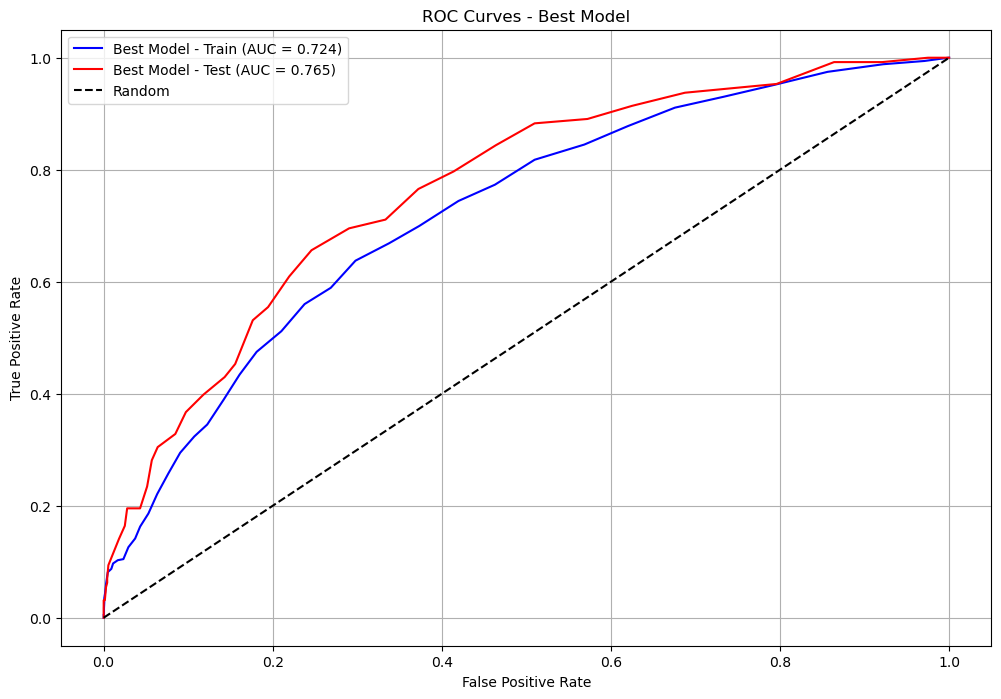

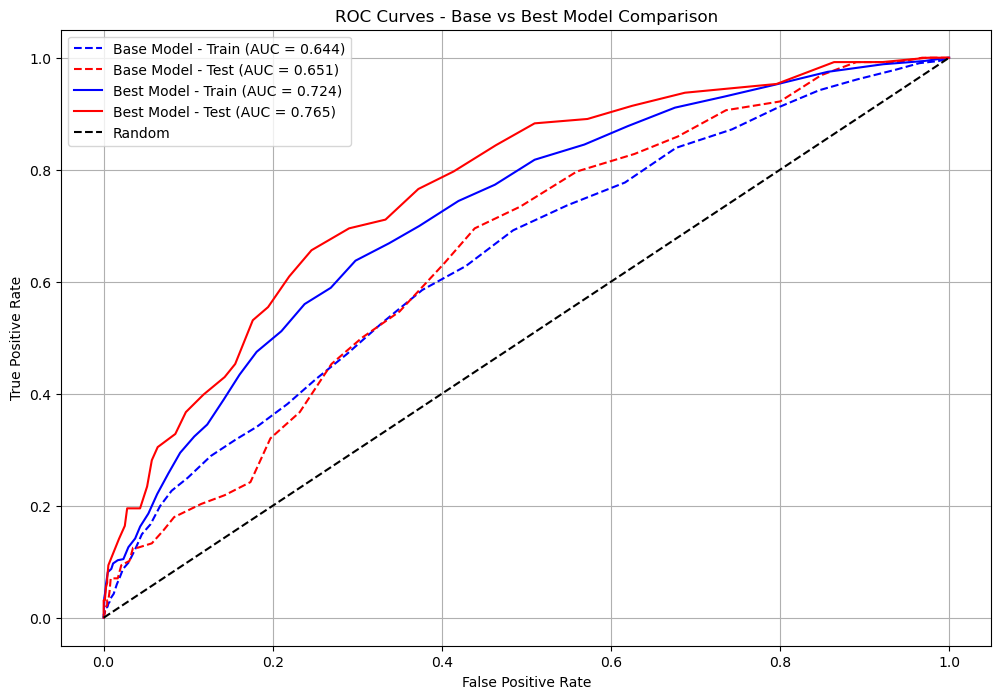

In [83]:
best_train_prob = sigmoid(np.dot(X_train_bias, best_metrics['weights']))
best_test_prob = sigmoid(np.dot(X_test_bias, best_metrics['weights']))
best_train_fpr, best_train_tpr = calculate_roc_points(y_train, best_train_prob)
best_test_fpr, best_test_tpr = calculate_roc_points(y_test, best_test_prob)
best_train_auc = calculate_auc(best_train_fpr, best_train_tpr)
best_test_auc = calculate_auc(best_test_fpr, best_test_tpr)

# Plot ROC curves
plt.figure(figsize=(12, 8))
plt.plot(best_train_fpr, best_train_tpr, 'b-', 
         label=f'Best Model - Train (AUC = {best_train_auc:.3f})')
plt.plot(best_test_fpr, best_test_tpr, 'r-', 
         label=f'Best Model - Test (AUC = {best_test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Best Model')
plt.legend()
plt.grid(True)
plt.show()

# Final comprehensive plot
plt.figure(figsize=(12, 8))
plt.plot(base_train_fpr, base_train_tpr, 'b--', 
         label=f'Base Model - Train (AUC = {base_train_auc:.3f})')
plt.plot(base_test_fpr, base_test_tpr, 'r--', 
         label=f'Base Model - Test (AUC = {base_test_auc:.3f})')
plt.plot(best_train_fpr, best_train_tpr, 'b-', 
         label=f'Best Model - Train (AUC = {best_train_auc:.3f})')
plt.plot(best_test_fpr, best_test_tpr, 'r-', 
         label=f'Best Model - Test (AUC = {best_test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Base vs Best Model Comparison')
plt.legend()
plt.grid(True)
plt.show()

### Analysis of ROC Curves and AUC Results

#### 1. Best Model - ROC Curve
- The first plot represents the ROC curve for the Best Model on both the training and test datasets.
- Train AUC:  0.724
- Test AUC: 0.765
   - The higher AUC for the test set compared to the training set indicates that the model generalizes well and performs better on unseen data.
  - The ROC curve illustrates strong predictive ability, with the Best Model distinguishing between the positive and negative classes effectively, especially when compared to random guessing (AUC = 0.5).
  - Both the train and test ROC curves follow similar paths, which suggests that there is no significant overfitting or underfitting of the model.

#### 2. Base vs. Best Model - ROC Curve Comparison
- The second plot compares the ROC curves for the Base Model and the Best Model for both training and test datasets.
- Base Model AUC:
  - Train: 0.644 
  - Test: 0.651
- Best Model AUC:
  - Train: 0.724
  - Test: 0.765
- The Best Model significantly outperforms the Base Model on both training and test datasets.
- The increase in AUC values from the Base Model to the Best Model (0.644 → 0.724 for training and 0.651 → 0.765 for testing) indicates a clear improvement in classification performance.
- The ROC curves of the Best Model show a much sharper increase in the true positive rate compared to the Base Model, highlighting better separation between the classes.
- The larger gap in AUC values between the Base and Best Models on both the training and test sets underscores the success of the improvements made, particularly through hyperparameter tuning.
- The Best Model's higher test AUC further emphasizes its ability to generalize and perform better on unseen data, making it more reliable for real-world applications.

In [85]:
# Comprehensive metrics comparison
print("\n" + "="*50)
print("Comprehensive Model Comparison")
print("="*50)

# Base Model Metrics
print("\nBase Model Metrics:")
base_train_pred = (base_train_prob >= 0.5).astype(int)
base_test_pred = (base_test_prob >= 0.5).astype(int)

print("\nTraining:")
base_train_metrics = compute_metrics(y_train, base_train_pred)
print("Confusion Matrix:")
print(base_train_metrics['confusion_matrix'])
print(f"Accuracy: {base_train_metrics['accuracy']:.4f}")
print(f"Precision: {base_train_metrics['precision']:.4f}")
print(f"Recall: {base_train_metrics['recall']:.4f}")
print(f"F1 Score: {base_train_metrics['f1_score']:.4f}")
print(f"AUC: {base_train_auc:.4f}")

print("\nTesting:")
base_test_metrics = compute_metrics(y_test, base_test_pred)
print("Confusion Matrix:")
print(base_test_metrics['confusion_matrix'])
print(f"Accuracy: {base_test_metrics['accuracy']:.4f}")
print(f"Precision: {base_test_metrics['precision']:.4f}")
print(f"Recall: {base_test_metrics['recall']:.4f}")
print(f"F1 Score: {base_test_metrics['f1_score']:.4f}")
print(f"AUC: {base_test_auc:.4f}")

# Best Model Metrics
print("\nBest Model Metrics:")
best_train_pred = (best_train_prob >= 0.5).astype(int)
best_test_pred = (best_test_prob >= 0.5).astype(int)

print("\nTraining:")
best_train_metrics = compute_metrics(y_train, best_train_pred)
print("Confusion Matrix:")
print(best_train_metrics['confusion_matrix'])
print(f"Accuracy: {best_train_metrics['accuracy']:.4f}")
print(f"Precision: {best_train_metrics['precision']:.4f}")
print(f"Recall: {best_train_metrics['recall']:.4f}")
print(f"F1 Score: {best_train_metrics['f1_score']:.4f}")
print(f"AUC: {best_train_auc:.4f}")

print("\nTesting:")
best_test_metrics = compute_metrics(y_test, best_test_pred)
print("Confusion Matrix:")
print(best_test_metrics['confusion_matrix'])
print(f"Accuracy: {best_test_metrics['accuracy']:.4f}")
print(f"Precision: {best_test_metrics['precision']:.4f}")
print(f"Recall: {best_test_metrics['recall']:.4f}")
print(f"F1 Score: {best_test_metrics['f1_score']:.4f}")
print(f"AUC: {best_test_auc:.4f}")


Comprehensive Model Comparison

Base Model Metrics:

Training:
Confusion Matrix:
[[2546  328]
 [ 382  134]]
Accuracy: 0.7906
Precision: 0.2900
Recall: 0.2597
F1 Score: 0.2740
AUC: 0.6437

Testing:
Confusion Matrix:
[[624  96]
 [101  27]]
Accuracy: 0.7677
Precision: 0.2195
Recall: 0.2109
F1 Score: 0.2151
AUC: 0.6512

Best Model Metrics:

Training:
Confusion Matrix:
[[2593  281]
 [ 358  158]]
Accuracy: 0.8115
Precision: 0.3599
Recall: 0.3062
F1 Score: 0.3309
AUC: 0.7238

Testing:
Confusion Matrix:
[[656  64]
 [ 85  43]]
Accuracy: 0.8243
Precision: 0.4019
Recall: 0.3359
F1 Score: 0.3660
AUC: 0.7648


### Base Model Metrics
#### Training
- Accuracy: 79.06%
- Precision: 29.00% – Of predicted positive cases, 29.00% were correct.
- Recall: 25.97% – The model identified only 25.97% of actual positive cases (CHD).
- F1 Score: 27.40% – Indicates poor balance between precision and recall, highlighting the challenge of identifying the positive class.
- AUC: 0.6437 – The model has a moderate ability to distinguish between the positive and negative classes but is still underperforming.
#### Testing:
- Accuracy: 76.77%
- Precision: 21.95% – Of predicted positive cases, only 21.95% were correct.
- Recall: 21.09% – Identified just 21.09% of actual positive cases.
- F1 Score: 21.51% – Consistent with training, showing the model’s struggle with classifying the minority class.
- AUC: 0.6512 – Slightly above random guessing, indicating that the model's ability to separate classes is still limited.
### Best Model Metrics
#### Training:
- Accuracy: 81.15%
- Precision: 35.99% – Improved from the Base Model, though still relatively low due to some false positives.
- Recall: 30.62% – Significant improvement in identifying positive cases compared to the Base Model.
- F1 Score:  33.09% – A better balance between precision and recall, indicating a better ability to classify positive cases.
- AUC: 0.7238 – Improved ability to distinguish between the positive and negative classes.
#### Testing:
- Accuracy: 82.43%
- Precision: 40.19% – Precision improved from the Base Model, with more correct predictions of positive cases.
- Recall: 33.59% – Further improvement in recall, identifying more positive cases compared to the Base Model.
- F1 Score:  36.60% – A clear improvement in overall predictive performance, indicating a better model balance.
- AUC: 0.7648 – A strong improvement, showing better generalization and ability to distinguish between the classes.

#### Interpretation:
- The Best Model outperforms the Base Model significantly across all metrics, particularly in recall, F1 score, and AUC. This suggests that the hyperparameter tuning process has effectively addressed the limitations of the Base Model and resulted in improved performance.
- The Best Model maintains consistent metrics between training and testing, demonstrating that it generalizes well without overfitting the training data.
- Recall vs Precision: The Best Model sacrifices some precision in exchange for a substantial gain in recall, which is crucial for applications where correctly identifying positive cases is more important than minimizing false positives.
- AUC Improvement: The AUC improvement from 0.6437 (Base Model) to 0.7648 (Best Model) reflects the model's better ability to distinguish between the positive and negative classes, making the Best Model more reliable for real-world applications, especially in scenarios where identifying positive cases is critical.